In [ ]:
!pip install emoji

     |████████████████████████████████| 175 kB 12.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f5794104d42a7cce9c31db8e506e1821c6123458799b47c9789ecb7c2bdaf508
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import HTML
import requests, json
from wordcloud import WordCloud
from textblob import TextBlob

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import sqlite3
import pickle
import nltk
nltk.download('stopwords')
%matplotlib inline


from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

dev = 'data/Twibot-20/dev.json'
train = 'data/Twibot-20/train.json'
test = 'data/Twibot-20/test.json'
#support = 'data/Twibot-20/support.json'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_json(train)
test_data = pd.read_json(test)

## Pre-processing

In [ ]:
df_train = train_data[['ID','tweet','label','domain']]
df_test = test_data[['ID','tweet','label','domain']]

In [ ]:
def count_tweets(tweets):
  t_count = 0
  rt_count = 0
  if tweets != None:
    for t in tweets:
      if t.split(" ")[0] == "RT":
        rt_count += 1
      else:
        t_count += 1

  return t_count, rt_count

In [ ]:
df_train['counts(t,rt)'] = df_train.tweet.map(count_tweets)

df_train['c_tweets'] = df_train['counts(t,rt)'].apply(lambda x: x[0])
df_train['c_retweets'] = df_train['counts(t,rt)'].apply(lambda x: x[1])


df_test['counts(t,rt)'] = df_test.tweet.map(count_tweets)

df_test['c_tweets'] = df_test['counts(t,rt)'].apply(lambda x: x[0])
df_test['c_retweets'] = df_test['counts(t,rt)'].apply(lambda x: x[1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
def sep_tweets(tweets):
  t_count = []
  rt_count = []
  if tweets != None:
    for t in tweets:
      if t.split(" ")[0] == "RT":
        rt_count.append(t)
      else:
        t_count.append(t)

  return t_count, rt_count


In [ ]:
df_train['sep(t,rt)'] = df_train.tweet.map(sep_tweets)

df_train['tweets'] = df_train['sep(t,rt)'].apply(lambda x: x[0])
df_train['retweets'] = df_train['sep(t,rt)'].apply(lambda x: x[1])
##---
df_test['sep(t,rt)'] = df_test.tweet.map(sep_tweets)

df_test['tweets'] = df_test['sep(t,rt)'].apply(lambda x: x[0])
df_test['retweets'] = df_test['sep(t,rt)'].apply(lambda x: x[1])


In [ ]:
def avg_length(tweets):
  length = 0
  if len(tweets) > 0:
    length = sum( map(len, tweets) ) / len(tweets)

  return length


In [ ]:
df_train['avg_len_tweets'] = df_train.tweets.map(avg_length)
df_train['avg_len_retweets'] = df_train.retweets.map(avg_length)

df_test['avg_len_tweets'] = df_test.tweets.map(avg_length)
df_test['avg_len_retweets'] = df_test.retweets.map(avg_length)

In [ ]:
def count_Char(tweets):
  length = 0
  if tweets != None:
    for t in tweets:
      length += t.count('#')

  return length

df_train['count_#'] = df_train.tweet.map(count_Char)
df_test['count_#'] = df_test.tweet.map(count_Char)

In [ ]:
def count_Char(tweets):
  length = 0
  if tweets != None:
    for t in tweets:
      length += t.count('@')

  return length

df_train['count_@'] = df_train.tweet.map(count_Char)
df_test['count_@'] = df_test.tweet.map(count_Char)

In [ ]:
def count_Char(tweets):
  length = 0
  if tweets != None:
    for t in tweets:
      length += t.count('http')

  return length

df_train['count_links'] = df_train.tweet.map(count_Char)
df_test['count_links'] = df_test.tweet.map(count_Char)

In [ ]:
from emoji import UNICODE_EMOJI

def is_emoji(tweets):
    count = 0
    if tweets != None:
      for emoji in UNICODE_EMOJI:
          for t in tweets:
            count += t.count(emoji)
    return count

df_train['count_emoji'] = df_train.tweet.map(is_emoji)
df_test['count_emoji'] = df_test.tweet.map(is_emoji)

In [ ]:
def count_duplicate(tweets):
  if tweets != None:
    return sum({i:tweets.count(i)-1 for i in tweets if tweets.count(i) > 1}.values())
  else:
    return 0

df_train['duplicates'] = df_train.tweet.map(count_duplicate)
df_test['duplicates'] = df_test.tweet.map(count_duplicate)

In [ ]:
def sentiment(tweets):
  sent_score = 0.0
  sub_score = 0.5
  if tweets != None:
    for t in tweets:
      score = TextBlob(t).sentiment
      sent_score += score.polarity
      sub_score += score.subjectivity
    sent_score = sent_score/len(tweets)
    sub_score = sub_score/len(tweets)
  return sent_score, sub_score

df_train['score(sent,sub)'] = df_train.tweet.map(sentiment)

df_train['sentiment'] = df_train['score(sent,sub)'].apply(lambda x: x[0])
df_train['subjectivity'] = df_train['score(sent,sub)'].apply(lambda x: x[1])

## ---

df_test['score(sent,sub)'] = df_test.tweet.map(sentiment)

df_test['sentiment'] = df_test['score(sent,sub)'].apply(lambda x: x[0])
df_test['subjectivity'] = df_test['score(sent,sub)'].apply(lambda x: x[1])

In [ ]:
# def subjective(tweets):
#   score = 0.5
#   if tweets != None:
#     for t in tweets:
#       score += TextBlob(t).sentiment.subjectivity
#   return score/len(tweets) if score > 0.5 else 0.5

# df['subjective'] = df.tweet.map(subjective)

In [ ]:
df_train.head()

,ID,tweet,label,domain,"counts(t,rt)",c_tweets,c_retweets,"sep(t,rt)",tweets,retweets,avg_len_tweets,avg_len_retweets,count_#,count_@,count_links,count_emoji,duplicates,"score(sent,sub)",sentiment,subjectivity
0,17461978,[RT @CarnivalCruise: 🎉 Are you ready to see wh...,0,"[Politics, Business, Entertainment]","(167, 33)",167,33,([Who has time for receipts? Not me. @epson re...,[Who has time for receipts? Not me. @epson rec...,[RT @CarnivalCruise: 🎉 Are you ready to see wh...,173.664671,128.878788,152,371,207,623,1,"(0.21677960482804223, 0.3982637911856664)",0.216780,0.398264
1,1297437077403885568,None,1,[Politics],"(0, 0)",0,0,"([], [])",[],[],0.000000,0.000000,0,0,0,0,0,"(0.0, 0.5)",0.000000,0.500000
2,17685258,[RT @realDonaldTrump: THANK YOU #RNC2020! http...,0,"[Politics, Entertainment, Sports]","(70, 130)",70,130,([Great takeaways from last night's Republican...,[Great takeaways from last night's Republican ...,[RT @realDonaldTrump: THANK YOU #RNC2020! http...,178.814286,117.800000,37,204,97,820,1,"(0.08637013558201058, 0.31903188191438214)",0.086370,0.319032
3,15750898,[A family fears they may have been cheated out...,0,[Politics],"(124, 76)",124,76,([A family fears they may have been cheated ou...,[A family fears they may have been cheated out...,"[RT @PaulFox13: Very sneaky, late-arriving #su...",191.532258,124.855263,61,100,173,747,0,"(0.1014539318836751, 0.3088337954373668)",0.101454,0.308834
4,1659167666,[RT @VonteThePlug: Yeah but he ain’t got one h...,1,[Politics],"(42, 46)",42,46,([Don’t let me find a bitch like Love cause I ...,[Don’t let me find a bitch like Love cause I p...,[RT @VonteThePlug: Yeah but he ain’t got one h...,70.047619,100.108696,6,55,59,90,0,"(0.015122921585989768, 0.3199387339302113)",0.015123,0.319939


In [ ]:
df_train = df_train.drop(['counts(t,rt)','sep(t,rt)','score(sent,sub)'], axis=1)
df_test = df_test.drop(['counts(t,rt)','sep(t,rt)','score(sent,sub)'], axis=1)

In [ ]:
df_test.head()

,ID,tweet,label,domain,c_tweets,c_retweets,tweets,retweets,avg_len_tweets,avg_len_retweets,count_#,count_@,count_links,count_emoji,duplicates,sentiment,subjectivity
0,1188812492010487808,[RT @clevelanddotcom: Three Ohio House Republi...,1,"[Politics, Sports]",35,165,"[@ArtValley818_ CaliRed.\n, @DavidNutzuki Thin...",[RT @clevelanddotcom: Three Ohio House Republi...,98.457143,117.090909,22,277,56,467,0,0.092744,0.299923
1,155659213,"[We touch our hair 96 times a day on average, ...",0,"[Politics, Business, Entertainment, Sports]",200,0,"[We touch our hair 96 times a day on average, ...",[],104.955000,0.000000,163,33,216,376,0,0.210296,0.316144
2,147725246,['He Looked Like He Knew What He Was Doing': C...,0,[Politics],175,25,['He Looked Like He Knew What He Was Doing': C...,[RT @FoxNews: McConnell: Dem Votes Against Kav...,118.817143,126.680000,15,249,197,439,37,0.120604,0.305429
3,1296248637194895360,"[Estamos abiertos a colaboraciones, por lo cuá...",1,[Politics],2,0,"[Estamos abiertos a colaboraciones, por lo cuá...",[],145.000000,0.000000,0,1,0,11,0,0.000000,0.250000
4,1339835893,[The suffragists chose purple and gold to repr...,0,"[Politics, Business, Entertainment, Sports]",148,52,[The suffragists chose purple and gold to repr...,[RT @colbertlateshow: TONIGHT: It's the final ...,168.290541,137.538462,41,173,165,683,0,0.175079,0.401478


In [ ]:
tweet_df_train = df_train
tweet_df_test = df_test

In [ ]:
tweet_df_train.head()

,ID,tweet,label,domain,c_tweets,c_retweets,tweets,retweets,avg_len_tweets,avg_len_retweets,count_#,count_@,count_links,count_emoji,duplicates,sentiment,subjectivity
0,17461978,[RT @CarnivalCruise: 🎉 Are you ready to see wh...,0,"[Politics, Business, Entertainment]",167,33,[Who has time for receipts? Not me. @epson rec...,[RT @CarnivalCruise: 🎉 Are you ready to see wh...,173.664671,128.878788,152,371,207,623,1,0.216780,0.398264
1,1297437077403885568,None,1,[Politics],0,0,[],[],0.000000,0.000000,0,0,0,0,0,0.000000,0.500000
2,17685258,[RT @realDonaldTrump: THANK YOU #RNC2020! http...,0,"[Politics, Entertainment, Sports]",70,130,[Great takeaways from last night's Republican ...,[RT @realDonaldTrump: THANK YOU #RNC2020! http...,178.814286,117.800000,37,204,97,820,1,0.086370,0.319032
3,15750898,[A family fears they may have been cheated out...,0,[Politics],124,76,[A family fears they may have been cheated out...,"[RT @PaulFox13: Very sneaky, late-arriving #su...",191.532258,124.855263,61,100,173,747,0,0.101454,0.308834
4,1659167666,[RT @VonteThePlug: Yeah but he ain’t got one h...,1,[Politics],42,46,[Don’t let me find a bitch like Love cause I p...,[RT @VonteThePlug: Yeah but he ain’t got one h...,70.047619,100.108696,6,55,59,90,0,0.015123,0.319939


In [ ]:
tweet_df_train.to_csv('text_data.csv')

## Plots

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8278 entries, 0 to 8277
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8278 non-null   int64  
 1   tweet             8223 non-null   object 
 2   label             8278 non-null   int64  
 3   c_tweets          8278 non-null   int64  
 4   c_retweets        8278 non-null   int64  
 5   tweets            8278 non-null   object 
 6   retweets          8278 non-null   object 
 7   avg_len_tweets    8278 non-null   float64
 8   avg_len_retweets  8278 non-null   float64
 9   count_#           8278 non-null   int64  
 10  count_@           8278 non-null   int64  
 11  count_links       8278 non-null   int64  
 12  count_emoji       8278 non-null   int64  
 13  duplicates        8278 non-null   int64  
 14  sentiment         8278 non-null   float64
 15  subjectivity      8278 non-null   float64
dtypes: float64(4), int64(9), object(3)
memory 

In [ ]:
import missingno as msno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

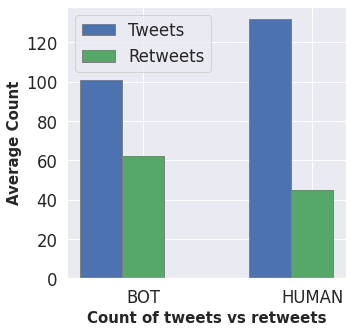

In [ ]:
## Plot of tweets and retweets

barWidth = 0.25
fig = plt.subplots(figsize =(5, 5))
 
# set height of bar
T = [df[df['label'] == 1].c_tweets.mean(), df[df['label'] == 0].c_tweets.mean()]
RT = [df[df['label'] == 1].c_retweets.mean(), df[df['label'] == 0].c_retweets.mean()]
 
# Set position of bar on X axis
br1 = np.arange(len(T))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, T, color ='b', width = barWidth,
        edgecolor ='grey', label ='Tweets')
plt.bar(br2, RT, color ='g', width = barWidth,
        edgecolor ='grey', label ='Retweets')
 
# Adding Xticks
plt.xlabel('Count of tweets vs retweets', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(T))],
        ['BOT', 'HUMAN'])
 
plt.legend()
plt.show()

No handles with labels found to put in legend.


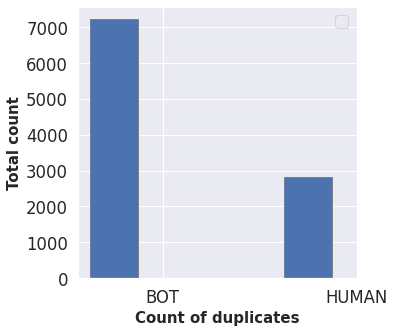

In [ ]:
## Count of duplicates

barWidth = 0.25
fig = plt.subplots(figsize =(5, 5))
 
# set height of bar
T = [df[df['label'] == 1].duplicates.sum(), df[df['label'] == 0].duplicates.sum()]
#RT = [df[df['label'] == 1].avg_len_retweets.mean(), df[df['label'] == 0].avg_len_retweets.mean()]
 
# Set position of bar on X axis
br1 = np.arange(len(T))
#br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, T, color ='b', width = barWidth,
        edgecolor ='grey')
# plt.bar(br2, RT, color ='g', width = barWidth,
#         edgecolor ='grey', label ='Retweets')
 
# Adding Xticks
plt.xlabel('Count of duplicates', fontweight ='bold', fontsize = 15)
plt.ylabel('Total count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(T))],
        ['BOT', 'HUMAN'])
 
plt.legend()
plt.show()

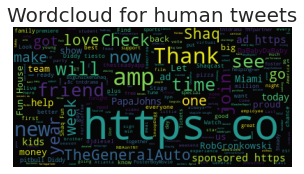

In [ ]:
tweets = df[df['label'] == 0]['tweets']


wc = WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(tweets.values[0]))

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Wordcloud for human tweets", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

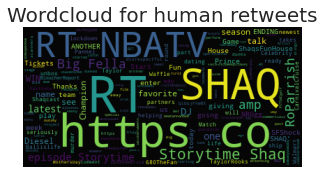

In [ ]:
tweets = df[df['label'] == 0]['retweets']


wc = WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(tweets.values[0]))

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Wordcloud for human retweets", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

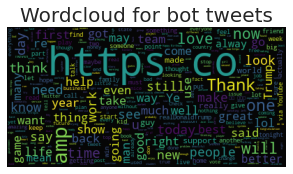

In [ ]:
tweets = df[df['label'] == 1]['tweets']


wc = WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(tweets.apply(lambda x: " ".join(x))))

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Wordcloud for bot tweets", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

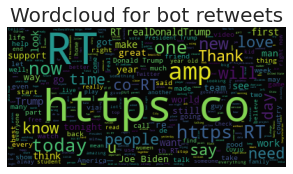

In [ ]:
tweets = df[df['label'] == 1]['retweets']


wc = WordCloud(background_color="black", max_words=1000)
wc.generate(" ".join(tweets.apply(lambda x: " ".join(x))))

plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Wordcloud for bot retweets", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

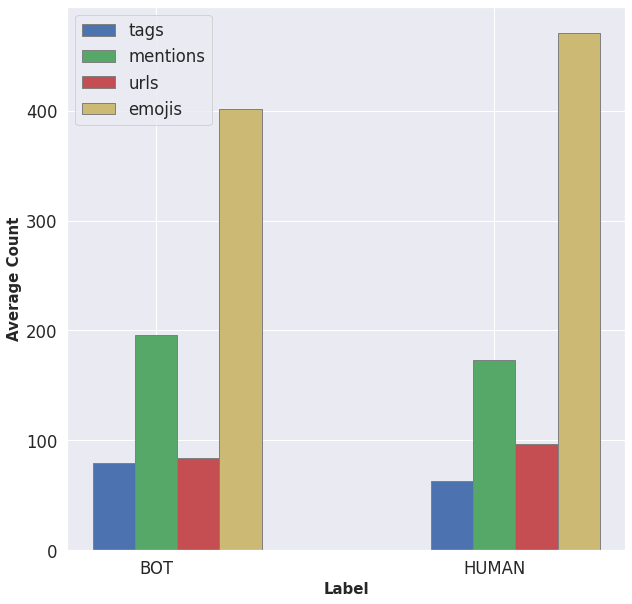

In [ ]:
barWidth = 0.125
fig = plt.subplots(figsize =(10, 10))
 
# set height of bar
hash = [df[df['label'] == 1]['count_#'].mean(), df[df['label'] == 0]['count_#'].mean()]
at = [df[df['label'] == 1]['count_@'].mean(), df[df['label'] == 0]['count_@'].mean()]
links = [df[df['label'] == 1]['count_links'].mean(), df[df['label'] == 0]['count_links'].mean()]
emoji = [df[df['label'] == 1]['count_emoji'].mean(), df[df['label'] == 0]['count_emoji'].mean()]

# Set position of bar on X axis
br1 = np.arange(len(hash))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

 
# Make the plot
plt.bar(br1, hash, color ='b', width = barWidth,
        edgecolor ='grey', label ='tags')
plt.bar(br2, at, color ='g', width = barWidth,
        edgecolor ='grey', label ='mentions')
plt.bar(br3, links, color ='r', width = barWidth,
        edgecolor ='grey', label ='urls')
plt.bar(br4, emoji, color ='y', width = barWidth,
        edgecolor ='grey', label ='emojis')
 
# Adding Xticks
plt.xlabel('Label', fontweight ='bold', fontsize = 15)
plt.ylabel('Average Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(hash))],
        ['BOT', 'HUMAN'])
 
plt.legend()
plt.show()

In [ ]:
len(bot[bot['sentiment'] > 0.0])

4313

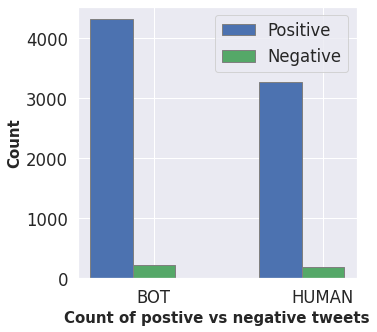

In [ ]:
## Plot of tweets and retweets

barWidth = 0.25
fig = plt.subplots(figsize =(5, 5))
 
# set height of bar
bot = df[df['label'] == 1]
human = df[df['label'] == 0]

pos = [len(bot[bot['sentiment'] > 0.0]), len(human[human['sentiment'] > 0.0])]
neg = [len(bot[bot['sentiment'] < 0.0]), len(human[human['sentiment'] < 0.0])]
 
# Set position of bar on X axis
br1 = np.arange(len(pos))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, pos, color ='b', width = barWidth,
        edgecolor ='grey', label ='Positive')
plt.bar(br2, neg, color ='g', width = barWidth,
        edgecolor ='grey', label ='Negative')
 
# Adding Xticks
plt.xlabel('Count of postive vs negative tweets', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(T))],
        ['BOT', 'HUMAN'])
 
plt.legend()
plt.show()

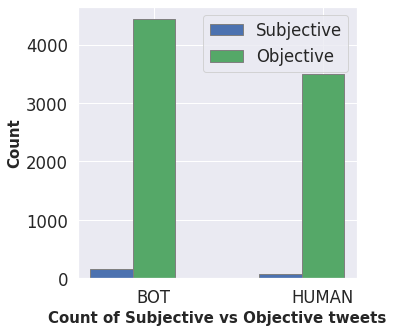

In [ ]:
## Plot of tweets and retweets

barWidth = 0.25
fig = plt.subplots(figsize =(5, 5))
 
# set height of bar
bot = df[df['label'] == 1]
human = df[df['label'] == 0]

sub = [len(bot[bot['subjectivity'] > 0.5]), len(human[human['subjectivity'] > 0.5])]
obj = [len(bot[bot['subjectivity'] < 0.5]), len(human[human['subjectivity'] < 0.5])]
 
# Set position of bar on X axis
br1 = np.arange(len(pos))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, sub, color ='b', width = barWidth,
        edgecolor ='grey', label ='Subjective')
plt.bar(br2, obj, color ='g', width = barWidth,
        edgecolor ='grey', label ='Objective')
 
# Adding Xticks
plt.xlabel('Count of Subjective vs Objective tweets', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(T))],
        ['BOT', 'HUMAN'])
 
plt.legend()
plt.show()

## Models


### Baseline

In [ ]:
def expand(tweets):
  return " ".join(tweets)

df_train['raw_text'] = df_train.tweet.apply(lambda x: " ".join(x[:5]) if x != None else "")
df_test['raw_text'] = df_test.tweet.apply(lambda x: " ".join(x[:5]) if x != None else "")


In [ ]:
stemmer = PorterStemmer()

def tokenize_and_clean_sentence(sentence, stopwords):
    result = []
    clean_sentence = re.sub("[^a-zA-Z]", " ", sentence)
    tokens = tweet_tokenizer.tokenize(clean_sentence)
    for token in tokens:
        candidate = token.strip().lower() 
        if candidate not in stopwords:
            result.append(stemmer.stem(candidate))
    
    return " ".join(result)

In [ ]:
nltk.download('stopwords')
words = stopwords.words("english")

df_train['cleaned'] = df_train['raw_text'].apply(
    lambda x: tokenize_and_clean_sentence(x, words)
)
df_test['cleaned'] = df_test['raw_text'].apply(
    lambda x: tokenize_and_clean_sentence(x, words)
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
vectorizer = TfidfVectorizer(
    min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 3)
)
tfidf_train = vectorizer.fit_transform(df_train['cleaned']).toarray()
print(tfidf_train.shape)


tfidf_test = vectorizer.transform(df_test['cleaned']).toarray()
print(tfidf_test.shape)

(8278, 22897)
(1183, 22897)


#### Linear Regression


In [ ]:

X_train = tweet_df_train['cleaned']
y_train = tweet_df_train['label']
X_test = tweet_df_test['cleaned']
y_test = tweet_df_test['label']
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.39      0.49       543
           1       0.62      0.83      0.71       640

    accuracy                           0.63      1183
   macro avg       0.64      0.61      0.60      1183
weighted avg       0.64      0.63      0.61      1183

[[211 332]
 [106 534]]


#### Random Forest

In [ ]:
pipeline = Pipeline([('vect', vectorizer),
                    ('chi',  SelectKBest(chi2, k=5000)),
                     ('clf', RandomForestClassifier(n_estimators=1000, min_samples_leaf=3, random_state=0))])

model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       543
           1       0.63      0.79      0.70       640

    accuracy                           0.63      1183
   macro avg       0.63      0.62      0.61      1183
weighted avg       0.63      0.63      0.62      1183

[[242 301]
 [135 505]]


### With text features

- Count - tweets, retweets, tags, mentions, urls, emojis, duplicates
- Average length - tweets, retweets
- Sentiment and Subjectivity scores

With PCA(n_components=50) 

In [ ]:
feature_array_train = df_train[['c_tweets', 'c_retweets',	'avg_len_tweets',	'avg_len_retweets',	'count_#',	'count_@',	'count_links',
                        'count_emoji',	'duplicates',	'sentiment',	'subjectivity']].to_numpy()

feature_array_test = df_test[['c_tweets', 'c_retweets',	'avg_len_tweets',	'avg_len_retweets',	'count_#',	'count_@',	'count_links',
                        'count_emoji',	'duplicates',	'sentiment',	'subjectivity']].to_numpy()

In [ ]:
X_train = np.hstack((tfidf_train, feature_array_train))
X_test = np.hstack((tfidf_test, feature_array_test))

y_train = df_train[['label']].values.ravel()
y_test = df_test[['label']].values.ravel()

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8278, 22908), (8278,), (1183, 22908), (1183,))

In [ ]:
pca_features = PCA(n_components=50).fit(X_train)
print('Overall explained variance: {:.3f}'.format(np.sum(pca_features.explained_variance_ratio_)))

X_features_pca = pca_features.transform(X_train)

Overall explained variance: 1.000


In [ ]:
X_features_pca_test = pca_features.transform(X_test)

#### Linear Regression

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=2000).fit(X_features_pca, y_train)
y_pred = clf.predict(X_features_pca_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       543
           1       0.67      0.78      0.72       640

    accuracy                           0.68      1183
   macro avg       0.68      0.67      0.67      1183
weighted avg       0.68      0.68      0.67      1183



#### Random Forest

In [ ]:
clf = RandomForestClassifier(random_state=0).fit(X_features_pca, y_train)
y_pred = clf.predict(X_features_pca_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.60      0.65       543
           1       0.70      0.78      0.74       640

    accuracy                           0.70      1183
   macro avg       0.70      0.69      0.69      1183
weighted avg       0.70      0.70      0.70      1183

